In [10]:
import os

paths = {
    "test_other": "data/test/x/other",
    "test_guitar": "data/test/x/guitar",
    "train_other": "data/train/x/other",
    "train_guitar": "data/train/x/guitar"
}

for label, path in paths.items():
    if os.path.exists(path):
        num_files = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
        print(f"{label}: {num_files} files")
    else:
        print(f"{label}: ❌ directory does not exist")


test_other: 20 files
test_guitar: 20 files
train_other: 610 files
train_guitar: 700 files


In [3]:
import os
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
import pandas as pd

def format_time(seconds):
    h = int(seconds // 3600)
    m = int((seconds % 3600) // 60)
    s = int(seconds % 60)
    return f"{h}h {m}m {s}s"

def collect_audio_stats(folder_paths_dict):
    lengths = []
    channels = []
    labels = []
    channel_summary = defaultdict(list)

    for label, path in folder_paths_dict.items():
        if os.path.exists(path):
            files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
            for file_name in files:
                file_path = os.path.join(path, file_name)
                try:
                    data, sr = sf.read(file_path)
                    duration = len(data) / sr
                    num_channels = data.shape[1] if data.ndim > 1 else 1

                    lengths.append(duration)
                    channels.append(num_channels)
                    labels.append(label)
                    channel_summary[label].append(num_channels)
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
        else:
            print(f"{label}: ❌ directory does not exist")

    return np.array(lengths), np.array(channels), np.array(labels), channel_summary

def plot_total_lengths(labels, lengths):
    unique_labels = np.unique(labels)
    total_lengths = [lengths[labels == ul].sum() for ul in unique_labels]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(unique_labels, total_lengths, color=plt.cm.tab10.colors[:len(unique_labels)])
    plt.ylabel("Total Audio Length (seconds)")
    plt.title("Total Audio Length per Folder")
    plt.grid(axis='y')

    for bar, total_sec in zip(bars, total_lengths):
        time_str = format_time(total_sec)
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, time_str,
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

def plot_length_distribution(lengths_by_label, title="File Length Distribution"):
    plt.figure(figsize=(10, 5))
    for label, lengths in lengths_by_label.items():
        plt.hist(lengths, bins=30, alpha=0.6, label=label, edgecolor='black')
    plt.xlabel("File Length (seconds)")
    plt.ylabel("Number of Files")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def display_channel_count_table(channel_summary):
    channel_table = {}

    for label, ch_list in channel_summary.items():
        count = Counter(ch_list)
        channel_table[label] = dict(count)

    # Convert to DataFrame
    channel_df = pd.DataFrame.from_dict(channel_table, orient='index').fillna(0).astype(int)

    # Sort for consistency
    channel_df = channel_df.sort_index(axis=0).sort_index(axis=1)

    display(channel_df)



In [14]:
# --- Collect stats for base folders ---
lengths, channels, labels, channel_summary = collect_audio_stats(paths)


In [15]:
# Display number of channels across dataset
display_channel_count_table(channel_summary)

,1,2
test_guitar,12,8
test_other,5,15
train_guitar,699,1
train_other,468,142


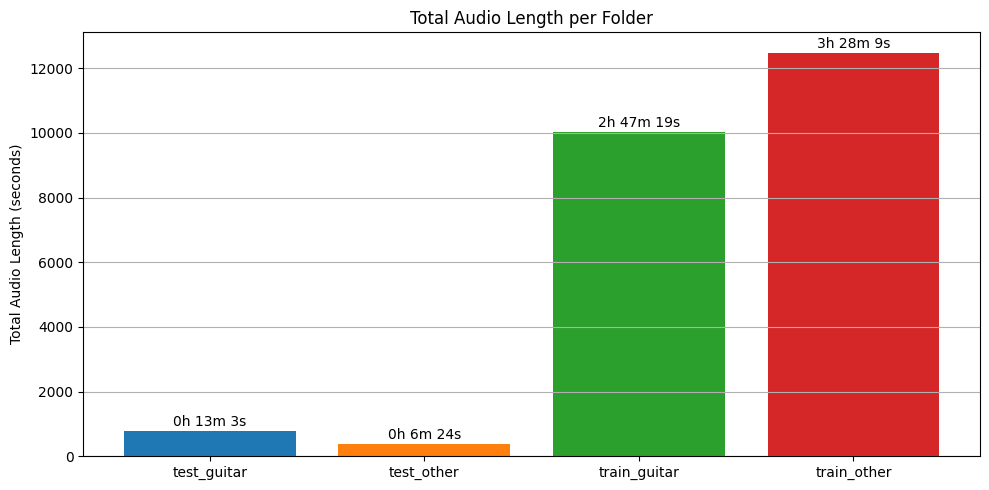

In [16]:
# Plot total durations
plot_total_lengths(labels, lengths)

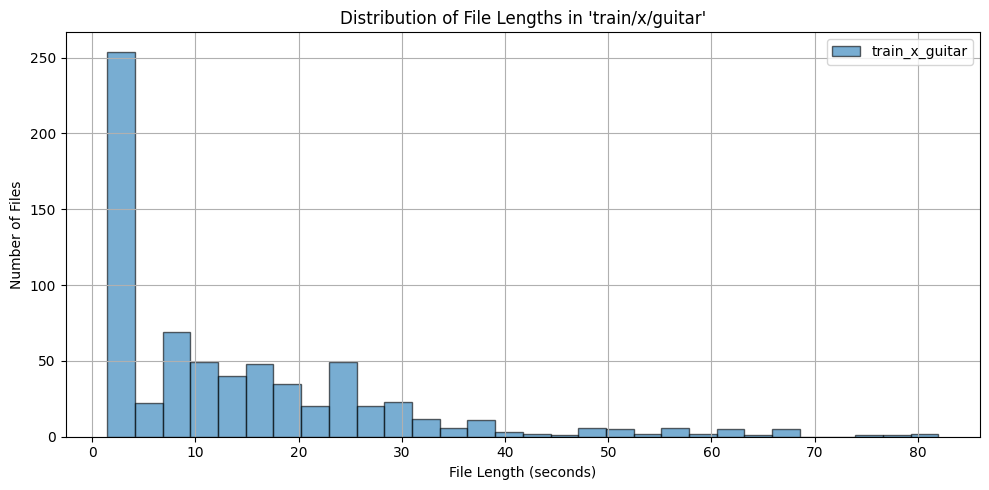

In [17]:
# Plot file length distribution for original train_guitar
train_guitar_lengths = lengths[labels == "train_guitar"]
plot_length_distribution({"train_x_guitar": train_guitar_lengths},
                         title="Distribution of File Lengths in 'train/x/guitar'")

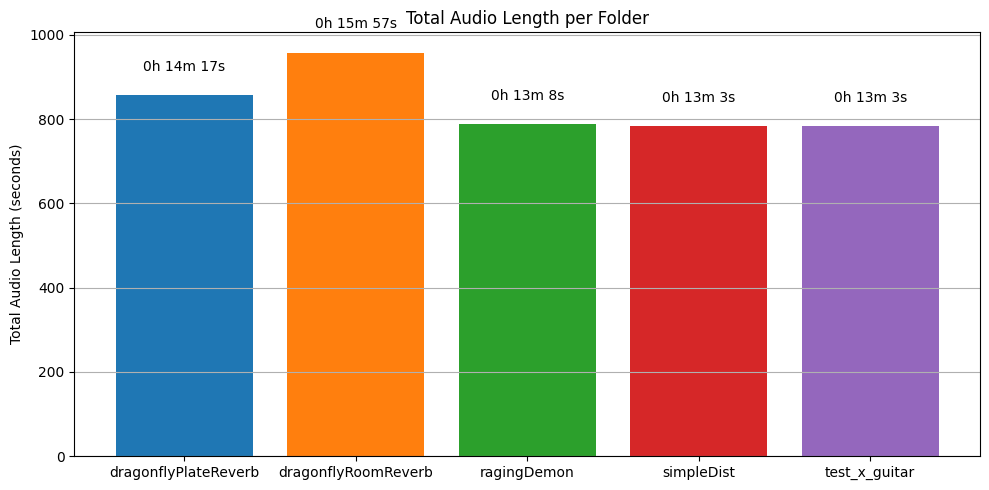

In [18]:
# --- Compare total lengths of test/x/guitar vs test/y/guitar/{effects} ---

effect_base_dir = "data/test/y/guitar"
effect_subdirs = [d for d in os.listdir(effect_base_dir)
                  if os.path.isdir(os.path.join(effect_base_dir, d))]

# Prepare path dict for all effects
effect_paths = {f"{effect}": os.path.join(effect_base_dir, effect)
                for effect in effect_subdirs}

# Add original test_x_guitar for comparison
effect_paths["test_x_guitar"] = "data/test/x/guitar"

# Collect stats
effect_lengths, _, effect_labels, _ = collect_audio_stats(effect_paths)

# Plot total durations
plot_total_lengths(effect_labels, effect_lengths)


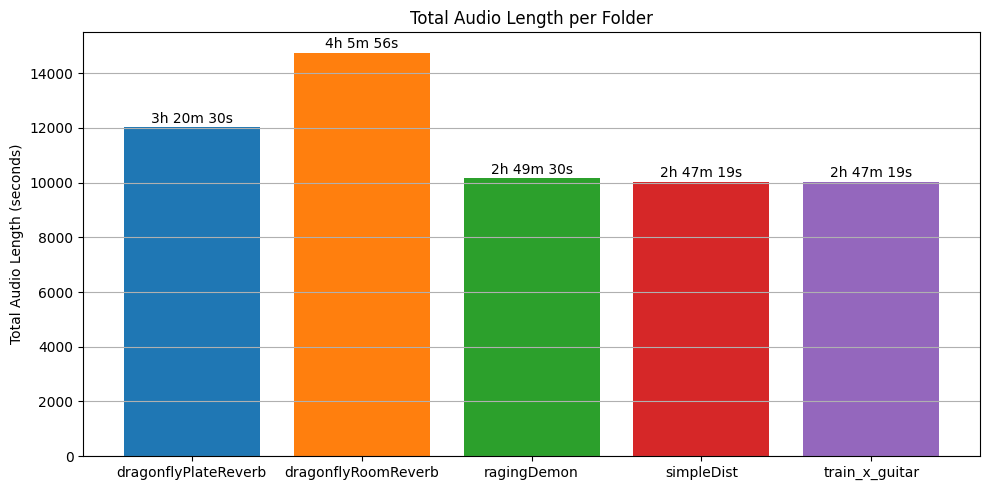

In [20]:
# --- Compare total lengths of test/x/guitar vs test/y/guitar/{effects} ---

effect_base_dir = "data/train/y/guitar"
effect_subdirs = [d for d in os.listdir(effect_base_dir)
                  if os.path.isdir(os.path.join(effect_base_dir, d))]

# Prepare path dict for all effects
effect_paths = {f"{effect}": os.path.join(effect_base_dir, effect)
                for effect in effect_subdirs}

# Add original test_x_guitar for comparison
effect_paths["train_x_guitar"] = "data/train/x/guitar"

# Collect stats
effect_lengths, _, effect_labels, _ = collect_audio_stats(effect_paths)

# Plot total durations
plot_total_lengths(effect_labels, effect_lengths)

In [ ]:
import torch

print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Using device:", torch.cuda.get_device_name(torch.cuda.current_device()))


CUDA Available: True
Number of GPUs: 1
Using device: NVIDIA GeForce GTX 1050 Ti


In [5]:
response_times = {
    "simpleDist": {"seconds": 0.000, "samples": 0},
    "ragingDemon": {"seconds": 0.188, "samples": 8271},
    "dragonflyPlateReverb": {"seconds": 2.844, "samples": 125413},
    "dragonflyRoomReverb": {"seconds": 6.738, "samples": 297165},
}

df = pd.DataFrame.from_dict(response_times, orient='index')

display(df)

,seconds,samples
simpleDist,0.000,0
ragingDemon,0.188,8271
dragonflyPlateReverb,2.844,125413
dragonflyRoomReverb,6.738,297165


In [17]:
# Inference Audio Test Notebook

import torch
import torchaudio
import IPython.display as ipd
import os

from models.baselineFCNet import BaselineFCNet  # Replace with your actual model class
from datasets.data_module import DataModule

# -------- Configuration --------
CHECKPOINT_PATH = "E:\\source\\dipl\\checkpoints\\baselineFC_simpleDist_10.pth"  # Adjust path
AUDIO_INDEX = 0  # Change to test different samples
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- Load Model --------
model = BaselineFCNet(
        hidden_size=5, 
        hidden_layers=2
    )  # Ensure your model class is correctly imported
model.load_state_dict(state_dict=torch.load(CHECKPOINT_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# -------- Load Data --------
data_module = DataModule(
        effect_name="simpleDist",
        batch_size=400,
        chunk_size=1102500, 
        num_workers=4,
        )  # Customize if your DataModule needs args
data_loader = data_module.test_dataloader()

# -------- Inference --------
# Pick a sample audio from the test loader
input_tensor, target_tensor = list(data_loader)[AUDIO_INDEX]
input_tensor = input_tensor.unsqueeze(0).to(DEVICE)  # Add batch dim

with torch.no_grad():
    output_tensor = model(input_tensor)

# Remove batch dim and move to CPU
input_audio = input_tensor.squeeze().cpu()
target_audio = target_tensor.squeeze().cpu()
output_audio = output_tensor.squeeze().cpu()

# -------- Play Audio --------
print("🔊 Input Audio")
ipd.display(ipd.Audio(input_audio.numpy(), rate=44100))

print("🎯 Target Audio (Ground Truth)")
ipd.display(ipd.Audio(target_audio.numpy(), rate=44100))

print("🚀 Output Audio (Model Prediction)")
ipd.display(ipd.Audio(output_audio.numpy(), rate=44100))


C:\Users\Ivkalu\AppData\Local\Temp\ipykernel_11400\2801283067.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(state_dict=torch.load(CHECKPOINT_PAT

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "e:\source\dipl\venv\lib\site-packages\torch\utils\data\_utils\worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "e:\source\dipl\venv\lib\site-packages\torch\utils\data\_utils\fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "e:\source\dipl\venv\lib\site-packages\torch\utils\data\_utils\collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "e:\source\dipl\venv\lib\site-packages\torch\utils\data\_utils\collate.py", line 211, in collate
    return [
  File "e:\source\dipl\venv\lib\site-packages\torch\utils\data\_utils\collate.py", line 212, in <listcomp>
    collate(samples, collate_fn_map=collate_fn_map)
  File "e:\source\dipl\venv\lib\site-packages\torch\utils\data\_utils\collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "e:\source\dipl\venv\lib\site-packages\torch\utils\data\_utils\collate.py", line 272, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [527616, 1] at entry 0 and [808704, 1] at entry 1
